# Problem 2

## (a) 
### Hidden layer:

1D Input → use shallow network (1–2 hidden layers)

2D or more dimension input → may need deeper network

### Node number:

Smooth, simple function→ small width (16–32)

Oscillatory / curved function→ moderate width (32–64)

Very complex function → larger width or extra layer

For this question, I choose 1 hidden layer and 32 nodes

## (b)
### Hidden layers: 

use ReLU as a good first choice (remember, it's just a good default, not a mandatory one).

### Output layer:

Regression (predict a real number, e.g., stock price differences): use Linear output.

Regression (predict a non-negative number, e.g., heights): use ReLU output. A special case of this is - predicting values between 0 and 1, say Probabilities - use Sigmoid output.

Binary classification (yes/no): use Sigmoid output (one node).

Multi-class classification (one of many classes): use Softmax (not covered yet in class) - don’t use a single sigmoid for this.

### My answer:
Hidden layer: ReLU

output layer: Linear

## (c)



![Loss Function](loss_function.png)

based on this rule, I choose MSE

## (d)

## Import the data

In [92]:
import pandas as pd

In [93]:
df = pd.read_csv('hw7_data.csv', header = None)

# By default, Pandas assumes the first row of your CSV contains column names (like "X" and "Y"). 
# Because your CSV doesn't have headers, Pandas is treating your very first data point as the column names

## Split data into two columns 

In [94]:
x = df.iloc[:, 0].to_numpy()

In [95]:
y = df.iloc[:, 1].to_numpy()

## Nomralize the data

In [96]:
x_normalized = (x - x.mean()) / x.std()
y_normalized = (y - y.mean()) / y.std()

In [97]:
x_normalized.shape

(100,)

## Convert data into tensor

In [98]:
import torch

In [99]:
x_t = torch.tensor(x_normalized, dtype=torch.float32).view(-1, 1)
y_t = torch.tensor(y_normalized, dtype=torch.float32).view(-1, 1)

# Convert the normalized data into a 2-dimensional float tensor that the neural network can read and process.

## Dataset & Dataloader

In [100]:
from torch.utils.data import TensorDataset, DataLoader

In [135]:
dataset = TensorDataset(x_t, y_t)
# Combine input tensor (x_t) and target tensor (y_t) into a dataset
# Each sample becomes a pair: (x, y)


loader = DataLoader(dataset, batch_size=100, shuffle=True)
# shuffle the order of pairs of data in the dataset and then splist the dataset into mini-batches
# 99 data & 32 batch --> batch1 32 pairs of data, batch2 32 pairs of data
# batch3 32 pairs of data, batch4 3 pairs of data


# A small dataset generally means fewer than 10,000 samples, 
# while fewer than 1,000 samples is considered very small. 
# dataset with 99 samples is considered very small or tiny.
# For small datasets, it is recommended to use smaller batch sizes such as 8, 16, or 32.
# In general, smaller datasets prefer smaller batches, and larger datasets can handle larger batch sizes.

## Model

In [136]:
import torch.nn as nn

In [137]:
model = nn.Sequential(     # generate the NNs
    nn.Linear(1, 32),      # the first hidden layer with 32 neurons (you choose the num of neurons before)
    nn.ReLU(),             # activation function (activation functions introduce non-linearity into the model)
    nn.Linear(32, 1)       # the output layer 
)

## Loss & Optimizer

In [138]:
loss_fn = nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# There are many optimizers. You may want to learn how to choose the loss_f and optimizers

## Training Loop

In [151]:
epochs = 1500   # how many times the model sees the entire dataset

# we have 4 mini-batch, 
# how many times the model can see the data: num_of_epochs * 4

for epoch in range(epochs):
    for xinl, yinl in loader:
        # Forward pass (model makes prediction)
        forw = model(xinl)

        # compute loss (measure prediction error)
        loss = loss_fn(forw, yinl)

        # Backward pass (compute gradients to know How much the loss will change if we change this weight)
        optimizer.zero_grad()
        loss.backward()

        # Update weights (Adjust weights to reduce loss actomatically)
        optimizer.step()

    if epoch % 150 == 0:
        print (f"Epoch {epoch}, Loss: {loss.item()}")

        # We print training information to monitor learning progress, detect problems,
        # and decide when to stop training.


Epoch 0, Loss: 0.128389373421669
Epoch 150, Loss: 0.1283103972673416
Epoch 300, Loss: 0.1283421367406845
Epoch 450, Loss: 0.12834377586841583
Epoch 600, Loss: 0.12830613553524017
Epoch 750, Loss: 0.12847737967967987
Epoch 900, Loss: 0.1282389760017395
Epoch 1050, Loss: 0.1281905174255371
Epoch 1200, Loss: 0.12819881737232208
Epoch 1350, Loss: 0.1283387541770935


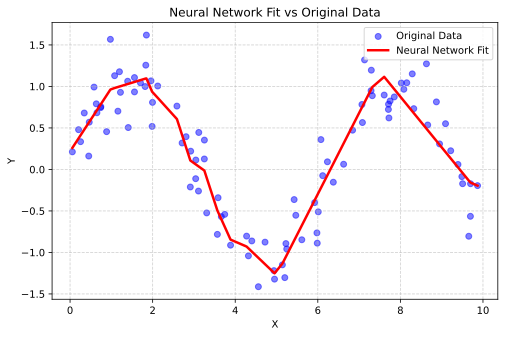

In [152]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Put the model in evaluation mode (good practice)
model.eval()

# 2. Get predictions from the trained model
# We use torch.no_grad() because we don't need to calculate gradients for plotting
with torch.no_grad():
    predictions_normalized = model(x_t).numpy()

# 3. Un-normalize the predictions back to the original scale
# Formula: original = (normalized * standard_deviation) + mean
predictions = (predictions_normalized * y.std()) + y.mean()

# 4. Sort the x values and predictions so the line plots smoothly
# If we don't sort, the line will zig-zag wildly connecting points in random order
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
predictions_sorted = predictions[sorted_indices]

# 5. Plot the results
plt.figure(figsize=(8, 5))

# Plot the original raw data as blue dots
plt.scatter(x, y, label='Original Data', color='blue', alpha=0.5)

# Plot the model's predictions as a red line
plt.plot(x_sorted, predictions_sorted, label='Neural Network Fit', color='red', linewidth=2.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Neural Network Fit vs Original Data')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Part E